# TASK 26: Hypernym Discovery



# 1.0 Libraries


In [1]:
!pip install langid
!pip install gensim
!pip install -U spacy
!python -m spacy download it_core_news_sm
!wget https://github.com/explosion/sense2vec/releases/download/v1.0.0/s2v_reddit_2015_md.tar.gz
!tar -xzvf s2v_reddit_2015_md.tar.gz
!pip install sense2vec
!pip install spacy_fastlang

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941172 sha256=c65254662a44b2c34821562804d0a13926b3b402a9c7b7988d0bdf2f5a2752b5
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 14.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
--2024-04-09 08:49:25--  https://github.com/explosion/sense2vec/releases/download/v1.0.0/s2v_reddit_2015_md.tar.gz
Resolving github.com (github.com)... 20.205.243.166
Connecting

In [2]:
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/gdrive')

import re
import json
import gensim.downloader as api

import langid
from gensim.models import Word2Vec
import spacy
import spacy_fastlang

from sense2vec import Sense2Vec
import random

import torch
from transformers import RobertaTokenizer
from transformers import RobertaForMultipleChoice
from torch.distributions import Categorical
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

import time
import warnings
warnings.filterwarnings('ignore')

Mounted at /content/gdrive


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


# 2.0 Set up

## Load Data

In [3]:
def load_data(data_path, gold_path):
  hypernyms_dict = {}
  with open(data_path, "r", encoding = 'utf-8') as data_file, open(gold_path, "r", encoding = 'utf-8') as gold_file:
    for data_line, gold_line in zip(data_file, gold_file):
      term_list = [term for term in data_line.split()[:-1]]
      term = " ".join(term_list)
      hypernyms = [hypernym.replace("\n", "") for hypernym in gold_line.split("\t")]
      hypernyms_dict[term] = hypernyms
  return hypernyms_dict

In [9]:
data_path = "/content/gdrive/MyDrive/Colab Notebooks/MNLP/Homework I - task 26/{split}/data/1B.italian.{split}.data.txt"
gold_path = "/content/gdrive/MyDrive/Colab Notebooks/MNLP/Homework I - task 26/{split}/gold/1B.italian.{split}.gold.txt"

# italian training data
train_data_path = data_path.format(split = 'training')
train_gold_path = gold_path.format(split = 'training')
train_hypernyms = load_data(train_data_path, train_gold_path)

# italian test data
test_data_path = data_path.format(split = 'test')
test_gold_path = gold_path.format(split = 'test')
test_hypernyms = load_data(test_data_path, test_gold_path)

In [10]:
# NLP pipeline to process italian language
nlp = spacy.load("it_core_news_sm")
nlp.add_pipe("language_detector")


def load_vocabulary(vocabulary_path):
  with open(vocabulary_path, "r", encoding = 'utf-8') as vocabulary_file:
    vocabulary = vocabulary_file.read().splitlines()
  return vocabulary


def detect_language(word):
  doc = nlp(word)
  language = doc._.language
  score = doc._.language_score
  return language, score


def clean_vocabulary(vocabulary):
  new_vocabulary = []
  for word in vocabulary:
    if word.isalpha(): # filter out numeric terms
      #language, confidence = langid.classify(word) # OLD VERSION: ineffective
      language, score = detect_language(word)
      if language == 'it' and score >= 0.5: # filter out non-italian words
        new_vocabulary.append(word)
  return new_vocabulary

## Load and clean Italian Vocabulary

In [11]:
# italian vocabulary
vocabulary_path = "/content/gdrive/MyDrive/Colab Notebooks/MNLP/Homework I - task 26/vocabulary/1B.italian.vocabulary.txt"
vocabulary = load_vocabulary(vocabulary_path)
print("Number of terms in the vocabulary: ", len(vocabulary), "\n")

# filtered italian vocabulary
vocabulary = clean_vocabulary(vocabulary)

# add hypernyms into vocabulary
for sublist_train, sublist_test in zip(train_hypernyms.values(), test_hypernyms.values()):
  vocabulary.extend(sublist_train)
  vocabulary.extend(sublist_test)

vocabulary = list(set(vocabulary)) # to avoid duplicates
print("Number of terms in the filtered vocabulary: ", len(vocabulary), "\n")
print("Preview of the first 20 terms in the vocabulary: ")
vocabulary[:20]

Number of terms in the vocabulary:  79715 

Number of terms in the filtered vocabulary:  14969 

Preview of the first 20 terms in the vocabulary: 


['manutenibilità',
 'organo',
 'divinazione',
 'febbrifugo',
 'sistemi di misurazione',
 'legadue',
 'svantaggio',
 'interposizione',
 'suddito',
 'uguagliare',
 'adottati',
 'sparizione',
 'vibratore',
 'riabilitazione',
 'dissotterrare',
 'esiliato',
 'villareggia',
 'colaggio',
 'malformazione',
 'autorevolezza']

# 3.0 Find distractors and create entries

## First Approach: Sense2Vec

In [12]:
# sense2vec model
s2v_model = Sense2Vec().from_disk('./s2v_old')

In [15]:
sense = s2v_model.get_best_sense("gatto")
s2v_model.most_similar(sense, n=5)

[('frutto|NOUN', 0.8995),
 ('sapore|NOUN', 0.899),
 ('biglietto|NOUN', 0.8961),
 ('integrazione|NOUN', 0.8921),
 ('addosso|NOUN', 0.8905)]

In [17]:
sense = s2v_model.get_best_sense("cane")
s2v_model.most_similar(sense, n=5)

[('walking_stick|NOUN', 0.8448),
 ('walking_cane|NOUN', 0.7377),
 ('gloved_hand|NOUN', 0.7154),
 ('gingerly|ADV', 0.7131),
 ('large_man|NOUN', 0.6988)]


**Main issues:**
*   Time constraints;
*   Presence of unrelated and non-italian distractors because the model is mainly trained using an English vocabulary.




## Second Approach: Word2Vec

In [18]:
# word2vec model using existing vocabulary
sentences = [vocabulary]
w2v_model = Word2Vec(sentences, min_count=1)

In [19]:
def find_distractors(hypernym, data, term, num_distractors):
  distractors = w2v_model.wv.most_similar(hypernym, topn = 5)
  filtered_distractors = [distractor[0] for distractor in distractors if distractor[0] not in data[term]]
  return filtered_distractors[:num_distractors]

def save_jsonl(file_path, data):
  id_seq = 0
  with open(file_path, "w") as output_file:
    for term, hypernyms in data.items():
      for hypernym in hypernyms:
        distractors = find_distractors(hypernym, data, term, num_distractors = 3)
        entries = (hypernym, *distractors)
        choices = list(entries)
        random.shuffle(choices) # to create randomness
        reformatted_json_data = {
              'id' : id_seq,
              'text': term,
              'choices': choices,
              'label' : choices.index(hypernym)
        }
        json.dump(reformatted_json_data, output_file)
        output_file.write("\n")
        id_seq +=1

def read_lines_jsonl(file_path, num_lines):
  with open(file_path, 'r') as f:
    json_list = list(f)
    for line in json_list[:num_lines]:
      data = json.loads(line)
      print(data)

In [20]:
# train jsonl file
save_jsonl("hypernym_discovery-task26-train-data.jsonl", train_hypernyms)
read_lines_jsonl("hypernym_discovery-task26-train-data.jsonl", num_lines = 10) # preview of the first 10 lines

{'id': 0, 'text': 'sesto', 'choices': ['inalterabilità', 'grado', 'bareggio', 'arteriosclerotico'], 'label': 1}
{'id': 1, 'text': 'sesto', 'choices': ['lateralizzazione', 'accordatura', 'provvedimento', 'numero ordinale'], 'label': 3}
{'id': 2, 'text': 'sesto', 'choices': ['frazione', 'limitato', 'pellicola', 'concorrenza'], 'label': 0}
{'id': 3, 'text': 'sesto', 'choices': ['capodoglio', 'carica', 'asciugacapelli', 'ridisegnare'], 'label': 1}
{'id': 4, 'text': 'Sigillo', 'choices': ['ferromagnetico', 'massonico', 'comune', 'sultanato'], 'label': 2}
{'id': 5, 'text': 'Sigillo', 'choices': ['adottabile', 'baraccano', 'impostore', 'municipalità'], 'label': 3}
{'id': 6, 'text': 'Sigillo', 'choices': ['frutteto', 'dovuto', 'indebolirsi', 'comune italiano'], 'label': 3}
{'id': 7, 'text': 'Sigillo', 'choices': ['pellicola', 'frazione', 'concorrenza', 'limitato'], 'label': 1}
{'id': 8, 'text': 'Sigillo', 'choices': ['gagliardetto', 'disinfestante', 'paese', 'quincinetto'], 'label': 2}
{'id': 

In [21]:
# test jsonl file
save_jsonl("hypernym_discovery-task26-test-data.jsonl", test_hypernyms)
read_lines_jsonl("hypernym_discovery-task26-test-data.jsonl", num_lines = 10) # preview of the first 10 lines

{'id': 0, 'text': 'tecnologia', 'choices': ['spettacolo', 'maglio', 'disciplina', 'littore'], 'label': 2}
{'id': 1, 'text': 'tecnologia', 'choices': ['malnutrizione', 'produzione', 'test', 'depressione'], 'label': 1}
{'id': 2, 'text': 'tecnologia', 'choices': ['sovrimporre', 'scienza', 'papireto', 'foresta'], 'label': 1}
{'id': 3, 'text': 'schermata', 'choices': ['segatore', 'immagine', 'alesaggio', 'spazio vuoto'], 'label': 1}
{'id': 4, 'text': 'schermata', 'choices': ['illustrazione', 'tormento', 'etcì', 'seclì'], 'label': 0}
{'id': 5, 'text': 'schermata', 'choices': ['riproduzione', 'attenti', 'giurato', 'polarizzazione'], 'label': 0}
{'id': 6, 'text': 'schermata', 'choices': ['rappresentazione', 'semireazione', 'pretore', 'appropriatezza'], 'label': 0}
{'id': 7, 'text': 'schermata', 'choices': ['svegliare', 'motricità', 'declinazione', 'raffigurazione'], 'label': 3}
{'id': 8, 'text': 'schermata', 'choices': ['proiezione', 'trasmissione', 'trenzano', 'caparbietà'], 'label': 0}
{'id'

# 4.0 Prompt formulation

In [22]:
prompts = [
    "Il termine '{text}' può essere iperonimo di: \n a) {option1} \n b) {option2} \n c) {option3} \n d) {option4}",
    "Dato il termine '{text}', quale tra le seguenti parole è un suo iperonimo? \n a) {option1} \n b) {option2} \n c) {option3} \n d) {option4}",
    "Scegli l'iperonimo del termine '{text}': \n a) {option1} \n b) {option2} \n c) {option3} \n d) {option4}"
]

In [23]:
for prompt in prompts:
  print(prompt)
  print(" ")

Il termine '{text}' può essere iperonimo di: 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}
 
Dato il termine '{text}', quale tra le seguenti parole è un suo iperonimo? 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}
 
Scegli l'iperonimo del termine '{text}': 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}
 


In [24]:
def save_prompts_jsonl(prompts, file_path):
  json_prompts = []
  for prompt in prompts:
    json_prompts.append({"prompt": prompt})

  with open(file_path, "w") as output_file:
    for json_prompt in json_prompts:
      json.dump(json_prompt, output_file)
      output_file.write("\n")

In [25]:
save_prompts_jsonl(prompts, "hypernym_discovery-task26-prompts.jsonl")
read_lines_jsonl("hypernym_discovery-task26-prompts.jsonl", num_lines = 3)

{'prompt': "Il termine '{text}' può essere iperonimo di: \n a) {option1} \n b) {option2} \n c) {option3} \n d) {option4}"}
{'prompt': "Dato il termine '{text}', quale tra le seguenti parole è un suo iperonimo? \n a) {option1} \n b) {option2} \n c) {option3} \n d) {option4}"}
{'prompt': "Scegli l'iperonimo del termine '{text}': \n a) {option1} \n b) {option2} \n c) {option3} \n d) {option4}"}


# 5.0 Prompts Evaluation

In [26]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [27]:
def evaluate_prompt(tokenizer, model, prompt, data_file, zero_shot_classification = False):
  formatted_prompts, y_true, y_pred, score = [], [], [], []
  lines = 0

  with open(data_file, "r") as f:
    json_data = list(f)
    for line in json_data:
      pair = json.loads(line)
      id = pair['id']
      text = pair['text']
      choices = pair['choices']
      label = pair['label']

      formatted_prompt = prompt.format(text = text, option1 = choices[0], option2 = choices[1], option3 = choices[2], option4 = choices[3])
      inputs = tokenizer([formatted_prompt] * len(choices), choices,
                         padding = True, return_tensors = "pt").to(device)

      if zero_shot_classification:
        output = model(inputs, candidate_labels=choices)
        predicted_output = output['labels'][0]
        predicted_label = choices.index(predicted_output)
        prediction_score = output['scores'][0]
      else:
        labels = torch.tensor(len(choices) - 1).unsqueeze(0)
        with torch.no_grad():
          output = model(**{k: v.unsqueeze(0) for k, v in inputs.items()}, labels = labels)

        probabilities = torch.softmax(output["logits"][0], -1).tolist()
        predicted_label = np.argmax(probabilities)
        prediction_score = probabilities[predicted_label]

      formatted_prompts.append(formatted_prompt)
      y_true.append(label)
      y_pred.append(predicted_label)
      score.append(prediction_score)
      lines += 1

      # Lines limit for time constrains
      if lines == 1000:
          break

    return formatted_prompts, y_true, y_pred, score


def visualize_results(results, num_results):
  for prompt in range(len(results)):
    for n in range(num_results):
      print("Prompt: ", results[prompt][0][n])
      print("True label: ", results[prompt][1][n])
      print("Predicted label: ", results[prompt][2][n])
      print("Prediction score: ", round(results[prompt][3][n], 3))
      print("----------------------------------------------------------------")
      print(" ")

In [28]:
def compute_metrics(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
  recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
  f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)
  cf_matrix = confusion_matrix(y_true, y_pred)
  return accuracy, precision, recall, f1, cf_matrix


def visualize_statistics(model_name, metrics, type):
  for n in range(len(metrics)):
    print(f"{type} Statistics for the Prompt {n+1}")
    print("Prompt: ", prompts[n])

    print("Accuracy score: ", round(metrics[n][0], 3))
    print("Precision score: ", round(metrics[n][1], 3))
    print("Recall score: ", round(metrics[n][2], 3))
    print("F1-score: ", round(metrics[n][3], 3))

    # Confusion Matrix Plot
    cf_matrix = metrics[n][4]
    fig, ax = plt.subplots(figsize=(5, 3))
    sns.heatmap(cf_matrix, annot = True, fmt = '.0f')
    ax.set_title(f'{type} Confusion Matrix for Prompt {n+1} using {model_name}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    plt.show()

    print("Total Predictions: ", np.sum(cf_matrix))
    print("Correct Predictions: ", np.trace(cf_matrix))
    print("----------------------------------------------------------------")
    print(" ")


def visualize_statistics_table(model_name, train_metrics, test_metrics, prompts):
  table = []
  for id, prompt in enumerate(prompts):
    data = {}
    for dtype, metrics in zip(['Train', 'Test'], [train_metrics, test_metrics]):
      accuracy, f1 = metrics[id][0], metrics[id][3]
      data[f'{dtype} Accuracy {model_name}'] = round(accuracy, 3)
      data[f'{dtype} F1-score {model_name}'] = round(f1, 3)
    table.append(data)

  df_transposed = pd.DataFrame(table).transpose()
  df_transposed.columns = [f'Prompt {i+1}' for i in range(len(prompts))]

  return df_transposed

## 5.1 RoBERTa Fine-Tuned Race model for Multiple Choices

In [29]:
model_name = "LIAMF-USP/roberta-large-finetuned-race"
roberta_tokenizer = RobertaTokenizer.from_pretrained(model_name)
roberta_model = RobertaForMultipleChoice.from_pretrained(model_name, num_labels = 4).to(device)

tokenizer_config.json:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [30]:
start_time = time.time()
roberta_train_results, roberta_test_results = [], []

for prompt in prompts:
  formatted_prompt, y_true, y_pred, score = evaluate_prompt(roberta_tokenizer, roberta_model, prompt, "hypernym_discovery-task26-train-data.jsonl")
  roberta_train_results.append([formatted_prompt, y_true, y_pred, score])

  formatted_prompt, y_true, y_pred, score = evaluate_prompt(roberta_tokenizer, roberta_model, prompt, "hypernym_discovery-task26-test-data.jsonl")
  roberta_test_results.append([formatted_prompt, y_true, y_pred, score])

end_time = time.time()
print("Execution Time: ", (end_time - start_time)/60, "minutes")

Execution Time:  5.675932689507802 minutes


In [31]:
visualize_results(roberta_train_results, num_results = 2) # preview of the first 2 train results for each prompt

Prompt:  Il termine 'sesto' può essere iperonimo di: 
 a) inalterabilità 
 b) grado 
 c) bareggio 
 d) arteriosclerotico
True label:  1
Predicted label:  3
Prediction score:  0.525
----------------------------------------------------------------
 
Prompt:  Il termine 'sesto' può essere iperonimo di: 
 a) lateralizzazione 
 b) accordatura 
 c) provvedimento 
 d) numero ordinale
True label:  3
Predicted label:  0
Prediction score:  0.778
----------------------------------------------------------------
 
Prompt:  Dato il termine 'sesto', quale tra le seguenti parole è un suo iperonimo? 
 a) inalterabilità 
 b) grado 
 c) bareggio 
 d) arteriosclerotico
True label:  1
Predicted label:  3
Prediction score:  0.454
----------------------------------------------------------------
 
Prompt:  Dato il termine 'sesto', quale tra le seguenti parole è un suo iperonimo? 
 a) lateralizzazione 
 b) accordatura 
 c) provvedimento 
 d) numero ordinale
True label:  3
Predicted label:  0
Prediction score: 

In [32]:
roberta_train_metrics, roberta_test_metrics = [], []

for prompt in range(len(prompts)):
  accuracy, precision, recall, f1, cf_matrix = compute_metrics(roberta_train_results[prompt][1], roberta_train_results[prompt][2])
  roberta_train_metrics.append([accuracy, precision, recall, f1, cf_matrix])

  accuracy, precision, recall, f1, cf_matrix = compute_metrics(roberta_test_results[prompt][1], roberta_test_results[prompt][2])
  roberta_test_metrics.append([accuracy, precision, recall, f1, cf_matrix])

### Statistics

Train Statistics for the Prompt 1
Prompt:  Il termine '{text}' può essere iperonimo di: 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}
Accuracy score:  0.256
Precision score:  0.262
Recall score:  0.256
F1-score:  0.231


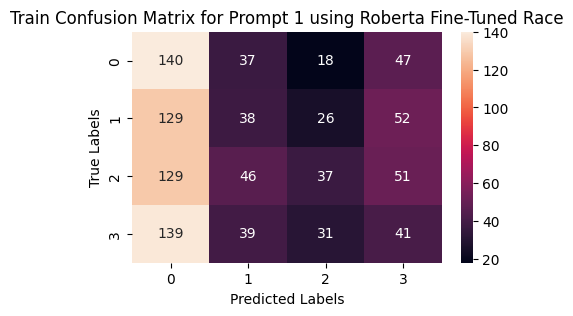

Total Predictions:  1000
Correct Predictions:  256
----------------------------------------------------------------
 
Train Statistics for the Prompt 2
Prompt:  Dato il termine '{text}', quale tra le seguenti parole è un suo iperonimo? 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}
Accuracy score:  0.233
Precision score:  0.222
Recall score:  0.233
F1-score:  0.192


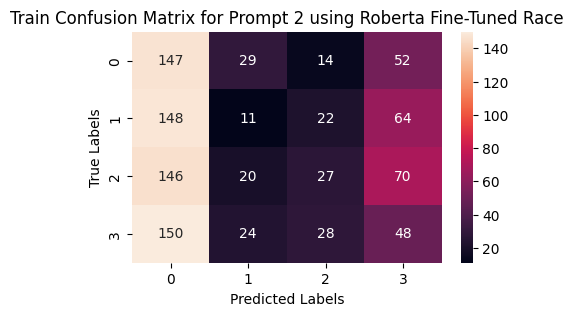

Total Predictions:  1000
Correct Predictions:  233
----------------------------------------------------------------
 
Train Statistics for the Prompt 3
Prompt:  Scegli l'iperonimo del termine '{text}': 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}
Accuracy score:  0.254
Precision score:  0.245
Recall score:  0.254
F1-score:  0.209


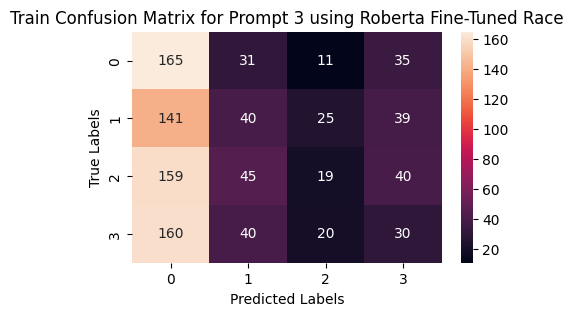

Total Predictions:  1000
Correct Predictions:  254
----------------------------------------------------------------
 


In [33]:
# Train Statistics for each prompt
visualize_statistics("Roberta Fine-Tuned Race", roberta_train_metrics, "Train")

Test Statistics for the Prompt 1
Prompt:  Il termine '{text}' può essere iperonimo di: 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}
Accuracy score:  0.3
Precision score:  0.297
Recall score:  0.3
F1-score:  0.273


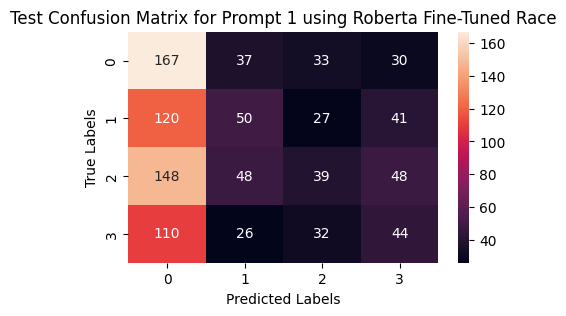

Total Predictions:  1000
Correct Predictions:  300
----------------------------------------------------------------
 
Test Statistics for the Prompt 2
Prompt:  Dato il termine '{text}', quale tra le seguenti parole è un suo iperonimo? 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}
Accuracy score:  0.283
Precision score:  0.286
Recall score:  0.283
F1-score:  0.247


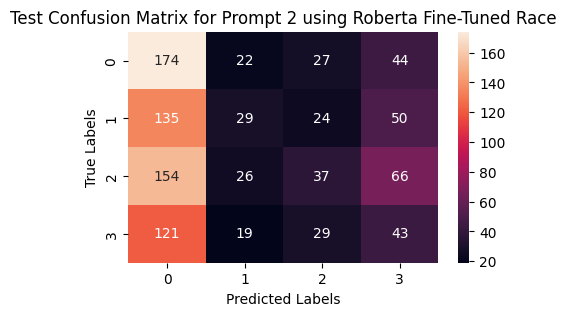

Total Predictions:  1000
Correct Predictions:  283
----------------------------------------------------------------
 
Test Statistics for the Prompt 3
Prompt:  Scegli l'iperonimo del termine '{text}': 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}
Accuracy score:  0.277
Precision score:  0.255
Recall score:  0.277
F1-score:  0.234


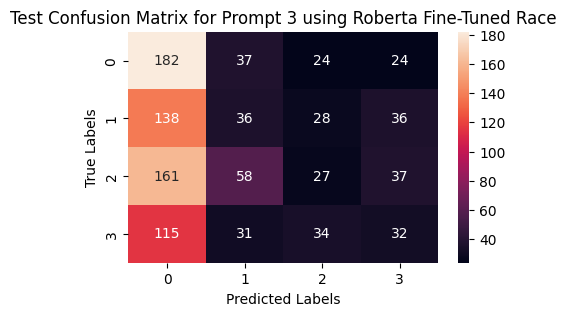

Total Predictions:  1000
Correct Predictions:  277
----------------------------------------------------------------
 


In [34]:
# Test Statistics for each prompt
visualize_statistics("Roberta Fine-Tuned Race", roberta_test_metrics, "Test")

In [35]:
# Overall Statistics Table
roberta_table = visualize_statistics_table("Roberta Fine-Tuned Race", roberta_train_metrics, roberta_test_metrics, prompts)
roberta_table

,Prompt 1,Prompt 2,Prompt 3
Train Accuracy Roberta Fine-Tuned Race,0.256,0.233,0.254
Train F1-score Roberta Fine-Tuned Race,0.231,0.192,0.209
Test Accuracy Roberta Fine-Tuned Race,0.300,0.283,0.277
Test F1-score Roberta Fine-Tuned Race,0.273,0.247,0.234


## 5.2 RoBERTa Large IT Multilingual Classifier for Zero Short Text Classification

In [44]:
model_name = 'Jiva/xlm-roberta-large-it-mnli'
roberta_tokenizer = AutoTokenizer.from_pretrained(model_name)
roberta_classifier = pipeline("zero-shot-classification",
                      model=model_name, batch_size = 8,
                      truncation=True, device = device)

In [45]:
start_time = time.time()
roberta_classifier_train_results, roberta_classifier_test_results = [], []

for prompt in prompts:
  formatted_prompt, y_true, y_pred, score = evaluate_prompt(roberta_tokenizer, roberta_classifier, prompt, "hypernym_discovery-task26-train-data.jsonl", True)
  roberta_classifier_train_results.append([formatted_prompt, y_true, y_pred, score])

  formatted_prompt, y_true, y_pred, score = evaluate_prompt(roberta_tokenizer, roberta_classifier, prompt, "hypernym_discovery-task26-test-data.jsonl", True)
  roberta_classifier_test_results.append([formatted_prompt, y_true, y_pred, score])

end_time = time.time()
print("Execution Time: ", (end_time - start_time)/60, "minutes")

Execution Time:  2.6396756251653035 minutes


In [46]:
visualize_results(roberta_classifier_train_results, num_results = 2) # preview of the first 2 train results for each prompt

Prompt:  Il termine 'sesto' può essere iperonimo di: 
 a) inalterabilità 
 b) grado 
 c) bareggio 
 d) arteriosclerotico
True label:  1
Predicted label:  1
Prediction score:  0.322
----------------------------------------------------------------
 
Prompt:  Il termine 'sesto' può essere iperonimo di: 
 a) lateralizzazione 
 b) accordatura 
 c) provvedimento 
 d) numero ordinale
True label:  3
Predicted label:  3
Prediction score:  0.268
----------------------------------------------------------------
 
Prompt:  Dato il termine 'sesto', quale tra le seguenti parole è un suo iperonimo? 
 a) inalterabilità 
 b) grado 
 c) bareggio 
 d) arteriosclerotico
True label:  1
Predicted label:  1
Prediction score:  0.322
----------------------------------------------------------------
 
Prompt:  Dato il termine 'sesto', quale tra le seguenti parole è un suo iperonimo? 
 a) lateralizzazione 
 b) accordatura 
 c) provvedimento 
 d) numero ordinale
True label:  3
Predicted label:  3
Prediction score: 

In [47]:
roberta_classifier_train_metrics, roberta_classifier_test_metrics = [], []

for prompt in range(len(prompts)):
  accuracy, precision, recall, f1, cf_matrix = compute_metrics(roberta_classifier_train_results[prompt][1], roberta_classifier_train_results[prompt][2])
  roberta_classifier_train_metrics.append([accuracy, precision, recall, f1, cf_matrix])

  accuracy, precision, recall, f1, cf_matrix = compute_metrics(roberta_classifier_test_results[prompt][1], roberta_classifier_test_results[prompt][2])
  roberta_classifier_test_metrics.append([accuracy, precision, recall, f1, cf_matrix])

### Statistics

Train Statistics for the Prompt 1
Prompt:  Il termine '{text}' può essere iperonimo di: 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}
Accuracy score:  0.274
Precision score:  0.274
Recall score:  0.274
F1-score:  0.274


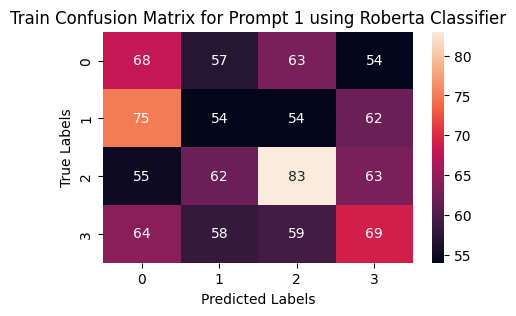

Total Predictions:  1000
Correct Predictions:  274
----------------------------------------------------------------
 
Train Statistics for the Prompt 2
Prompt:  Dato il termine '{text}', quale tra le seguenti parole è un suo iperonimo? 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}
Accuracy score:  0.274
Precision score:  0.274
Recall score:  0.274
F1-score:  0.274


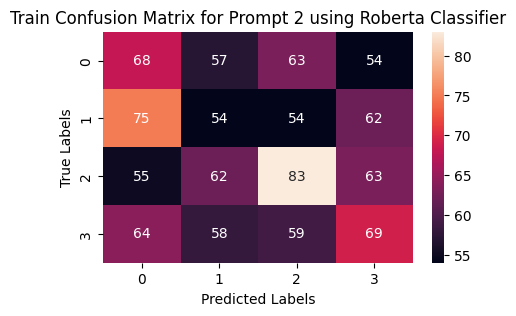

Total Predictions:  1000
Correct Predictions:  274
----------------------------------------------------------------
 
Train Statistics for the Prompt 3
Prompt:  Scegli l'iperonimo del termine '{text}': 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}
Accuracy score:  0.274
Precision score:  0.274
Recall score:  0.274
F1-score:  0.274


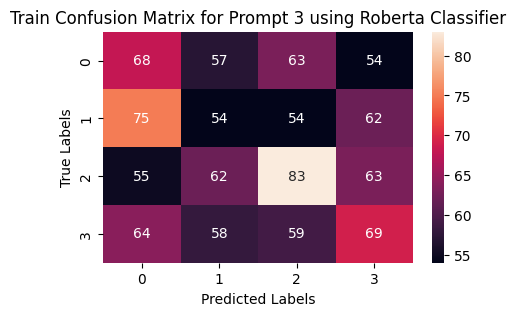

Total Predictions:  1000
Correct Predictions:  274
----------------------------------------------------------------
 


In [48]:
# Train Statistics for each prompt
visualize_statistics("Roberta Classifier", roberta_classifier_train_metrics, "Train")

Test Statistics for the Prompt 1
Prompt:  Il termine '{text}' può essere iperonimo di: 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}
Accuracy score:  0.247
Precision score:  0.246
Recall score:  0.247
F1-score:  0.246


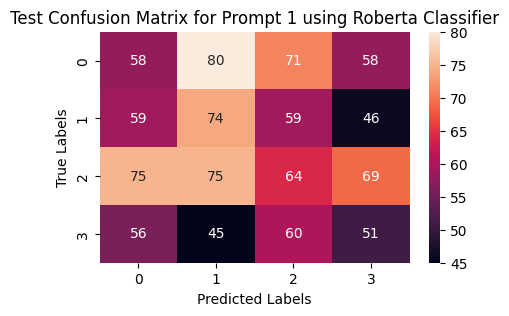

Total Predictions:  1000
Correct Predictions:  247
----------------------------------------------------------------
 
Test Statistics for the Prompt 2
Prompt:  Dato il termine '{text}', quale tra le seguenti parole è un suo iperonimo? 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}
Accuracy score:  0.247
Precision score:  0.246
Recall score:  0.247
F1-score:  0.246


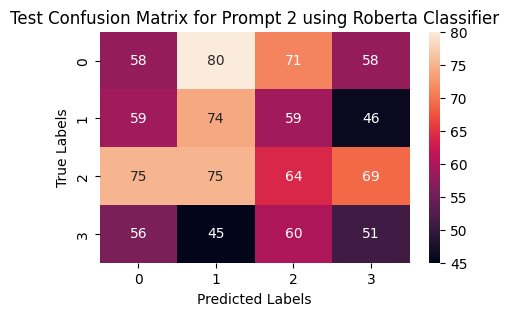

Total Predictions:  1000
Correct Predictions:  247
----------------------------------------------------------------
 
Test Statistics for the Prompt 3
Prompt:  Scegli l'iperonimo del termine '{text}': 
 a) {option1} 
 b) {option2} 
 c) {option3} 
 d) {option4}
Accuracy score:  0.247
Precision score:  0.246
Recall score:  0.247
F1-score:  0.246


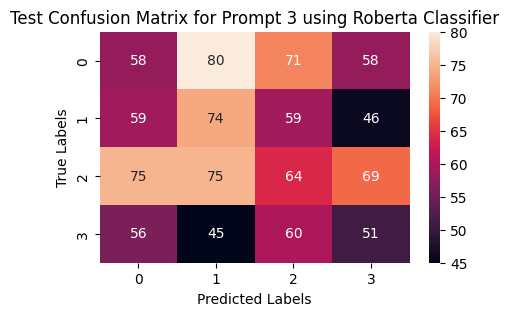

Total Predictions:  1000
Correct Predictions:  247
----------------------------------------------------------------
 


In [49]:
# Train Statistics for each prompt
visualize_statistics("Roberta Classifier", roberta_classifier_test_metrics, "Test")

In [50]:
# Overall Statistics Table
roberta_classifier_table = visualize_statistics_table("Roberta Large IT Multilingual", roberta_classifier_train_metrics, roberta_classifier_test_metrics, prompts)
roberta_classifier_table

,Prompt 1,Prompt 2,Prompt 3
Train Accuracy Roberta Large IT Multilingual,0.274,0.274,0.274
Train F1-score Roberta Large IT Multilingual,0.274,0.274,0.274
Test Accuracy Roberta Large IT Multilingual,0.247,0.247,0.247
Test F1-score Roberta Large IT Multilingual,0.246,0.246,0.246


# 5.3 Comparison

In [51]:
comparison_table = pd.concat([roberta_table, roberta_classifier_table])
comparison_table

,Prompt 1,Prompt 2,Prompt 3
Train Accuracy Roberta Fine-Tuned Race,0.256,0.233,0.254
Train F1-score Roberta Fine-Tuned Race,0.231,0.192,0.209
Test Accuracy Roberta Fine-Tuned Race,0.300,0.283,0.277
Test F1-score Roberta Fine-Tuned Race,0.273,0.247,0.234
Train Accuracy Roberta Large IT Multilingual,0.274,0.274,0.274
Train F1-score Roberta Large IT Multilingual,0.274,0.274,0.274
Test Accuracy Roberta Large IT Multilingual,0.247,0.247,0.247
Test F1-score Roberta Large IT Multilingual,0.246,0.246,0.246
